In [34]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

In [35]:
raw_dataset = pd.read_csv('ce475_project_data.csv', delimiter=';')
dataset = raw_dataset.copy()
test_data = dataset.tail(20)
dataset = dataset.drop(test_data.index)
mse = make_scorer(mean_squared_error)

In [36]:
dataset.head()

,x1,x2,x3,x4,x5,x6,Y
0,1,37,12,65,-18,1,1.0
1,27,14,6,85,11,27,-24.0
2,34,13,14,63,-16,34,4092.0
3,5,18,24,83,-4,5,121.0
4,31,44,10,57,-7,31,2441.0


In [37]:
test_data.head()

,x1,x2,x3,x4,x5,x6,Y
100,8,46,30,32,5,8,NaN
101,10,23,16,27,13,10,NaN
102,6,9,28,76,-20,6,NaN
103,11,31,3,46,-11,11,NaN
104,12,27,0,98,20,12,NaN


In [38]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      120 non-null    int64  
 1   x2      120 non-null    int64  
 2   x3      120 non-null    int64  
 3   x4      120 non-null    int64  
 4   x5      120 non-null    int64  
 5   x6      120 non-null    int64  
 6   Y       100 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 6.7 KB


In [39]:
pd.DataFrame(raw_dataset.isna().sum()).T

,x1,x2,x3,x4,x5,x6,Y
0,0,0,0,0,0,0,20


In [40]:
dataset.describe().T[['min', 'max', 'mean']]

,min,max,mean
x1,0.0,40.0,19.29
x2,0.0,50.0,22.53
x3,0.0,35.0,16.68
x4,0.0,100.0,50.60
x5,-20.0,20.0,-1.44
x6,0.0,40.0,19.29
Y,-42.0,12402.0,1746.82


In [41]:
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

In [42]:
dataset.corr()

,x1,x2,x3,x4,x5,x6,Y
x1,1.000000,-0.167880,-0.051437,-0.153805,0.091953,1.000000,0.300764
x2,-0.167880,1.000000,-0.047579,-0.072409,-0.191095,-0.167880,0.071139
x3,-0.051437,-0.047579,1.000000,0.106278,0.070286,-0.051437,0.280280
x4,-0.153805,-0.072409,0.106278,1.000000,-0.137413,-0.153805,0.122084
x5,0.091953,-0.191095,0.070286,-0.137413,1.000000,0.091953,-0.508310
x6,1.000000,-0.167880,-0.051437,-0.153805,0.091953,1.000000,0.300764
Y,0.300764,0.071139,0.280280,0.122084,-0.508310,0.300764,1.000000


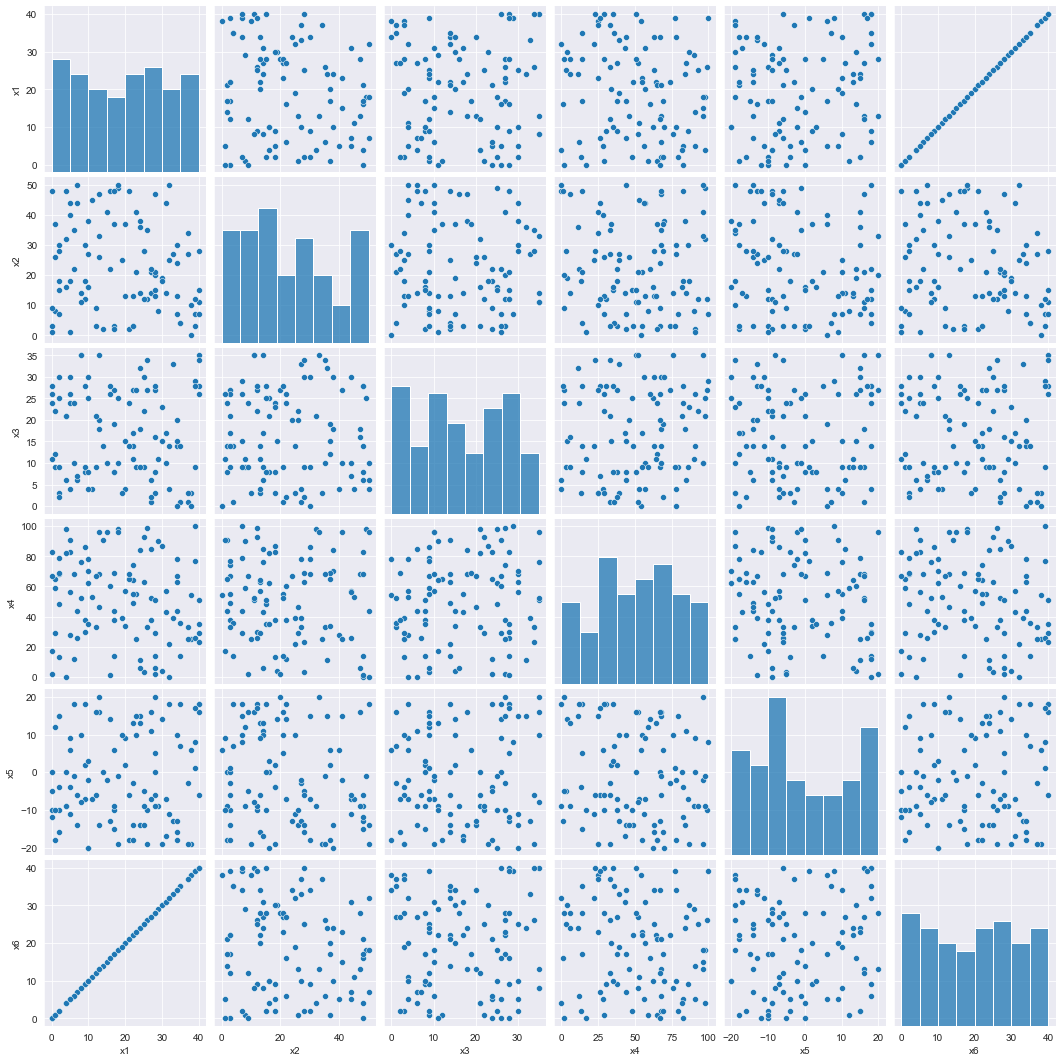

In [43]:
sns.pairplot(dataset[predictors])

In [44]:
dataset.drop(columns=['x6'], inplace=True, axis=1)
test_data.drop(columns=['x6'], inplace=True, axis=1)
predictors.remove('x6')
predictors

['x1', 'x2', 'x3', 'x4', 'x5']

In [45]:
dataset.describe().transpose()[['min', 'max', 'mean']]

,min,max,mean
x1,0.0,40.0,19.29
x2,0.0,50.0,22.53
x3,0.0,35.0,16.68
x4,0.0,100.0,50.60
x5,-20.0,20.0,-1.44
Y,-42.0,12402.0,1746.82


### Linear Regression

In [46]:
def linear_regression(x, y, pred=None):
    if pred is None:
        pred = predictors
    cv_score = np.sqrt(cross_val_score(estimator=LinearRegression(), X=x[pred], y=y, cv=5, scoring=mse))
    cv_pred = cross_val_predict(estimator=LinearRegression(), X=x[pred], y=y, cv=5)
    lr = LinearRegression()
    lr.fit(x, y)
    y_pred = lr.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

In [47]:
_, cv_predictions, _ = linear_regression(x=dataset[predictors], y=dataset['Y'])

<AxesSubplot:xlabel='x5', ylabel='Y'>

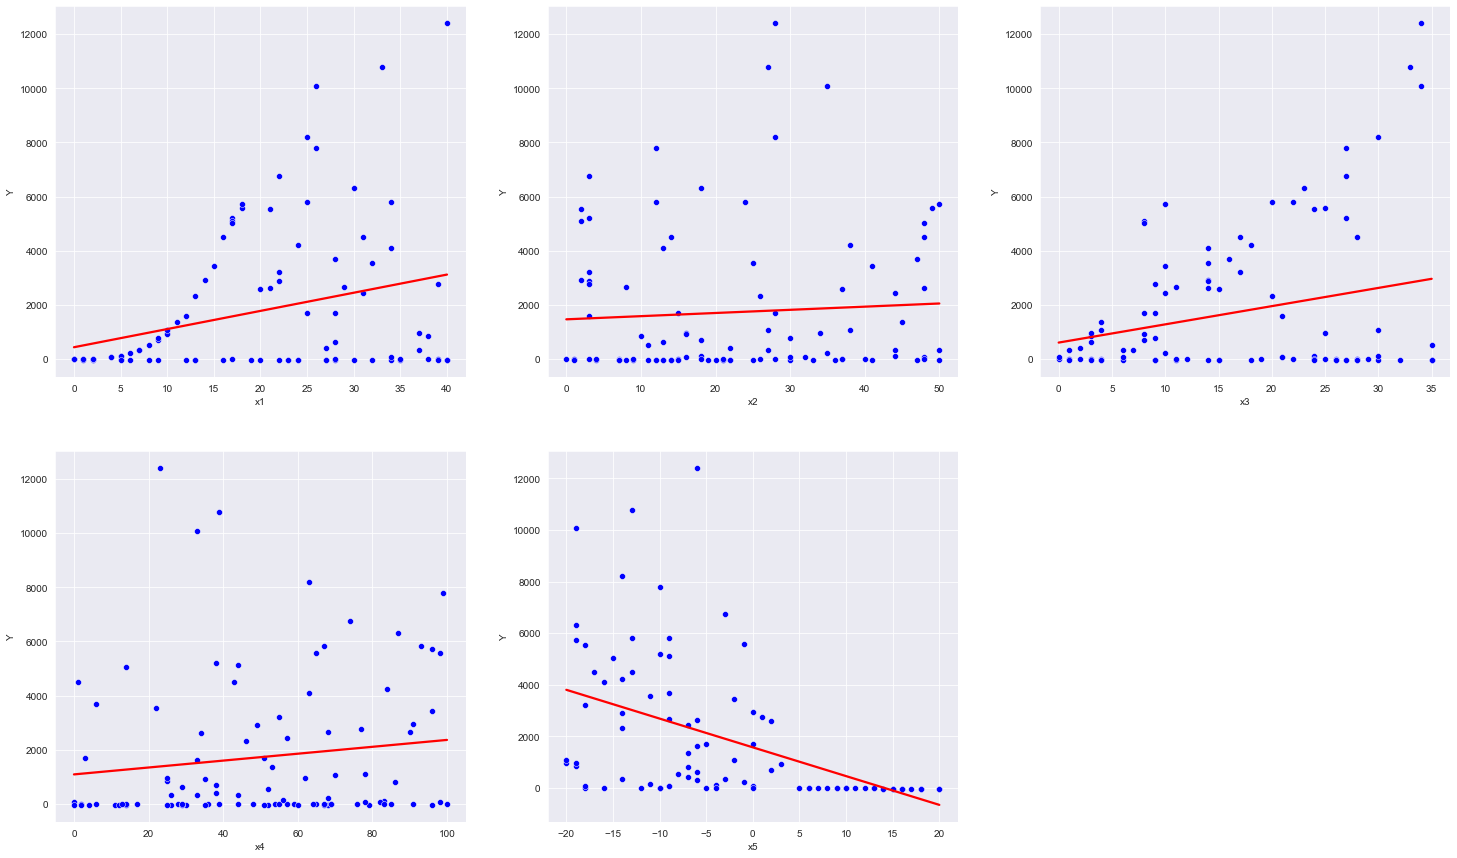

In [48]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 3, 1)
sns.scatterplot(x=dataset['x1'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x1'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 2)
sns.scatterplot(x=dataset['x2'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x2'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 3)
sns.scatterplot(x=dataset['x3'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x3'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 4)
sns.scatterplot(x=dataset['x4'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x4'], y=cv_predictions, color='r', scatter=False, ci=False)

plt.subplot(2, 3, 5)
sns.scatterplot(x=dataset['x5'], y=dataset['Y'], color='b')
sns.regplot(x=dataset['x5'], y=cv_predictions, color='r', scatter=False, ci=False)

In [49]:
lin_reg_errors = pd.DataFrame()

for i in predictors:
    lin_pred, cv_predictions, rmse_score = linear_regression(x=dataset[predictors], y=dataset['Y'], pred=[i])
    lin_reg_errors.loc['rmse', i] = np.mean(rmse_score)

lin_reg_errors.sort_values(by='rmse', axis=1, ascending=True)

,x5,x1,x3,x4,x2
rmse,2284.881476,2558.030689,2567.476732,2609.239499,2650.673638


In [50]:
pd.DataFrame(data=min(lin_reg_errors.min(axis=1)), columns=lin_reg_errors.idxmin(axis=1), index=['rmse'])

,x5
rmse,2284.881476


### Multiple Linear Regression

In [51]:
def all_combinations(pred, n=2):
    comb = []
    for k in range(n, len(pred) + 1):
        comb.extend(list(combinations(pred, k)))
    return list(map(list, comb))

In [52]:
predictor_combinations = all_combinations(pred=predictors)

In [53]:
def multiple_linear_regression(x, y, pred=None):
    cv_score = np.sqrt(cross_val_score(estimator=LinearRegression(), X=x[pred], y=y, cv=5,
                               scoring=mse))
    cv_pred = cross_val_predict(estimator=LinearRegression(), X=x[pred], y=y, cv=5)
    lr = LinearRegression()
    lr.fit(x, y)
    y_pred = lr.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

In [54]:
multi_lin_reg_errors = pd.DataFrame()

for i in predictor_combinations:
    lin_pred, cv_predictions, rmse_score = multiple_linear_regression(x=dataset[predictors], y=dataset['Y'], pred=i)
    multi_lin_reg_errors.loc[f'rmse', f'{i}'] = np.mean(rmse_score)

multi_lin_reg_errors.sort_values('rmse', axis=1, ascending=True)

,"['x1', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x4', 'x5']","['x3', 'x5']","['x1', 'x2', 'x4', 'x5']","['x1', 'x5']","['x3', 'x4', 'x5']","['x1', 'x2', 'x5']",...,"['x1', 'x3', 'x4']","['x1', 'x2', 'x3']","['x1', 'x3']","['x1', 'x2', 'x4']","['x1', 'x4']","['x1', 'x2']","['x3', 'x4']","['x2', 'x3']","['x2', 'x3', 'x4']","['x2', 'x4']"
rmse,1991.396429,1996.237096,2001.107878,2003.695876,2153.215578,2163.451841,2164.517283,2166.116951,2176.616007,2181.650425,...,2460.933037,2464.81067,2470.603104,2508.800002,2520.190686,2557.556585,2575.854631,2592.634599,2599.486401,2635.789506


In [55]:
pd.DataFrame(data=min(multi_lin_reg_errors.min(axis=1)), columns=multi_lin_reg_errors.idxmin(axis=1), index=['rmse'])

,"['x1', 'x3', 'x5']"
rmse,1991.396429


#### K-Nearest Neighbors Regression (KNN)

In [56]:
def k_nearest_neighbors(x, y, k, pred=None):
    cv_score = np.sqrt(cross_val_score(estimator=KNeighborsRegressor(n_neighbors=k), X=x[pred], y=y, cv=5,
                               scoring=mse))
    cv_pred = cross_val_predict(estimator=KNeighborsRegressor(n_neighbors=k), X=x[pred], y=y, cv=5)
    knn = KNeighborsRegressor()
    knn.fit(x, y)
    y_pred = knn.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

In [57]:
knn_errors = pd.DataFrame()

for i in predictor_combinations:
    for j in range(1, 6):
        knn_pred, cv_predictions, rmse_score = k_nearest_neighbors(x=dataset[predictors], y=dataset['Y'], k=j, pred=i)
        knn_errors.loc[f'k={j}', f'{i}'] = np.mean(rmse_score)

knn_errors.sort_values('k=1', axis=1)

,"['x1', 'x3', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x5']","['x1', 'x4', 'x5']","['x1', 'x2', 'x5']","['x1', 'x2', 'x3']","['x1', 'x2', 'x3', 'x4']","['x3', 'x4', 'x5']",...,"['x2', 'x4', 'x5']","['x1', 'x3']","['x1', 'x4']","['x4', 'x5']","['x2', 'x3']","['x3', 'x4']","['x2', 'x5']","['x2', 'x3', 'x4']","['x1', 'x2', 'x4']","['x2', 'x4']"
k=1,998.614011,1502.612137,1851.190792,1912.336640,2078.649429,2257.332464,2258.639434,2284.383224,2695.336470,2728.791018,...,3080.959161,3112.307131,3142.880372,3233.242412,3354.251376,3404.177818,3473.989385,3527.915476,3559.341814,3706.117239
k=2,1095.949318,1366.891639,1779.410189,1874.374497,1803.183438,2130.955516,2038.876348,1949.364104,2205.907209,2682.600063,...,2840.000271,2447.752304,2829.098639,2804.288832,3113.833953,2995.635624,2862.723591,2973.446153,2814.364748,3023.011915
k=3,1097.203971,1407.935587,1732.129623,1554.570040,1616.522425,2299.432869,1949.109410,2351.633144,2195.512527,2490.239027,...,2828.004618,2361.905983,2681.474549,2652.547255,2872.081337,2876.299833,2744.763411,2708.759265,2674.020728,3123.081620
k=4,1177.520259,1459.852014,1812.862359,1652.516710,1599.472060,2296.985084,1949.573692,2309.871240,2201.154375,2457.256560,...,2731.623977,2185.809256,2658.785059,2496.591503,2835.608390,2812.232242,2548.136386,2721.368970,2725.997343,3046.700820
k=5,1202.734601,1439.102296,1876.852361,1679.521972,1631.786478,2338.805261,1947.942047,2345.822653,2330.037642,2282.563212,...,2781.249942,2209.931484,2644.595885,2428.797337,2730.899985,2812.530886,2485.928827,2668.917204,2672.097249,3025.852833


In [58]:
lowest_knn_error = pd.DataFrame(data=min(knn_errors.min(axis=1)), columns=knn_errors.idxmin(axis=1), index=['rmse'])
lowest_knn_error.index.name = knn_errors.index[knn_errors[knn_errors.idxmin(axis=1)[0]] == min(knn_errors.min(axis=1))].values[0]
pd.DataFrame(lowest_knn_error.iloc[:, 0])

,"['x1', 'x3', 'x5']"
k=1,
rmse,998.614011


#### Decision Tree Regression

In [59]:
def decision_tree_regression(x, y, d, pred=None):
    cv_score = np.sqrt(cross_val_score(estimator=DecisionTreeRegressor(random_state=0, max_depth=d), X=x[pred], y=y, cv=5, scoring=mse))
    cv_pred = cross_val_predict(estimator=DecisionTreeRegressor(random_state=0, max_depth=d), X=x[pred], y=y, cv=5)
    dt = DecisionTreeRegressor(random_state=0, max_depth=d)
    dt.fit(x, y)
    y_pred = dt.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

In [60]:
dec_tree_errors = pd.DataFrame()

for i in predictor_combinations:
    for j in range(1, 6):
        dt_pred, cv_predictions, rmse_score = decision_tree_regression(x=dataset[predictors], y=dataset['Y'], d=j, pred=i)
        dec_tree_errors.loc[f'depth={j}', f'{i}'] = np.mean(rmse_score)

dec_tree_errors.sort_values('depth=5', axis=1)

,"['x1', 'x3', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x5']","['x1', 'x2', 'x5']","['x1', 'x2', 'x4', 'x5']","['x1', 'x4', 'x5']","['x2', 'x3', 'x5']","['x2', 'x3', 'x4', 'x5']",...,"['x3', 'x4']","['x4', 'x5']","['x1', 'x3', 'x4']","['x1', 'x2', 'x3', 'x4']","['x1', 'x2']","['x2', 'x5']","['x1', 'x2', 'x4']","['x1', 'x4']","['x2', 'x4', 'x5']","['x2', 'x4']"
depth=1,2458.257958,2458.257958,2458.257958,2458.257958,2458.257958,2458.257958,2458.257958,2458.257958,2458.257958,2458.257958,...,2702.097000,2458.257958,2401.946407,2401.946407,2401.946407,2458.257958,2401.946407,2401.946407,2458.257958,2643.078311
depth=2,2102.610335,2102.610335,2219.013376,2219.013376,1846.604563,1846.604563,1963.007604,1963.007604,2363.435495,2475.455412,...,2651.218387,2541.723105,2631.759285,2631.759285,2563.794230,2485.976050,2555.881562,2557.516718,2541.723105,2952.421948
depth=3,1484.839573,1484.839573,1621.562926,1621.562926,1817.684556,1817.684556,1946.683919,1946.683919,2051.857761,2100.428094,...,2773.993048,2598.505892,2839.682424,2839.682424,2478.719084,2404.403678,2689.605512,2772.403172,2713.781479,2854.274188
depth=4,982.251027,1096.477796,1290.528320,1174.816204,1913.957504,1979.053162,2120.288271,2094.806214,2179.860153,2550.627611,...,2809.233158,2834.762567,2855.129995,2859.699763,2465.583101,2869.483638,2751.636038,2954.880236,2971.957962,3109.159097
depth=5,810.639987,926.196812,1011.510451,1117.572859,1852.566587,1984.436158,2003.819152,2099.611839,2272.368785,2325.608955,...,2872.457320,2892.179895,2905.221508,2911.597363,2918.638265,3000.277161,3081.208125,3225.594706,3270.620763,3699.643095


In [61]:
lowest_dec_tree_error = pd.DataFrame(data=min(dec_tree_errors.min(axis=1)), columns=dec_tree_errors.idxmin(axis=1), index=['rmse'])
lowest_dec_tree_error.index.name = dec_tree_errors.index[dec_tree_errors[dec_tree_errors.idxmin(axis=1)[-1]] == min(dec_tree_errors.min(axis=1))].values[0]
pd.DataFrame(lowest_dec_tree_error.iloc[:, 0])

,"['x1', 'x2']"
depth=5,
rmse,810.639987


#### Random Forest Regression

In [62]:
def random_forest_regression(x, y, d, pred=None):
    cv_score = np.sqrt(cross_val_score(estimator=RandomForestRegressor(random_state=0, max_depth=d), X=x[pred], y=y, cv=5, scoring=mse))
    cv_pred = cross_val_predict(estimator=RandomForestRegressor(random_state=0, max_depth=d), X=x[pred], y=y, cv=5)
    rf = RandomForestRegressor(random_state=0, max_depth=d)
    rf.fit(x, y)
    y_pred = rf.predict(test_data[predictors])

    return y_pred, cv_pred, cv_score

In [63]:
rf_errors = pd.DataFrame()

for i in predictor_combinations:
    for j in range(1, 6):
        rf_pred, cv_predictions, rmse_score = random_forest_regression(x=dataset[predictors], y=dataset['Y'], d=j, pred=i)
        rf_errors.loc[f'depth={j}', f'{i}'] = np.mean(rmse_score)


rf_errors.sort_values('depth=5', axis=1)

,"['x1', 'x3', 'x5']","['x1', 'x2', 'x3', 'x5']","['x1', 'x3', 'x4', 'x5']","['x1', 'x2', 'x3', 'x4', 'x5']","['x1', 'x5']","['x1', 'x2', 'x5']","['x1', 'x4', 'x5']","['x1', 'x2', 'x4', 'x5']","['x2', 'x3', 'x5']","['x3', 'x5']",...,"['x1', 'x2']","['x2', 'x3']","['x4', 'x5']","['x2', 'x4', 'x5']","['x2', 'x3', 'x4']","['x1', 'x2', 'x4']","['x1', 'x4']","['x3', 'x4']","['x2', 'x5']","['x2', 'x4']"
depth=1,2356.091069,2359.611832,2359.168594,2362.773671,2348.223884,2351.270213,2349.692405,2352.843672,2358.992196,2355.332111,...,2484.558568,2629.846110,2379.302957,2381.462724,2634.980389,2491.542800,2491.529337,2627.733143,2383.668652,2648.590183
depth=2,1905.561181,1926.926758,1935.930940,1937.209435,1851.131341,1874.702114,1890.602498,1912.161872,2168.311776,2163.694143,...,2415.911445,2507.319495,2405.110117,2394.501573,2530.889827,2444.467908,2468.024361,2505.387612,2362.035445,2722.639740
depth=3,1427.811517,1460.884114,1520.330653,1548.467443,1732.034713,1781.252371,1797.998214,1825.837856,2123.963125,2161.363758,...,2468.405849,2510.166321,2443.363240,2456.252139,2518.304784,2522.518294,2561.545227,2517.046218,2427.254848,2754.223026
depth=4,1069.219869,1115.321056,1215.889912,1237.402606,1660.324171,1750.071523,1745.040156,1802.690854,2115.006419,2179.781040,...,2430.639556,2507.030110,2505.917264,2510.871712,2523.635639,2565.774898,2595.212471,2566.843295,2528.622392,2829.055550
depth=5,948.816949,1012.620665,1125.386245,1153.173456,1625.040358,1717.221402,1763.741060,1815.864711,2146.791272,2190.919110,...,2462.322123,2472.644796,2549.162589,2566.818427,2573.987421,2605.238477,2609.763227,2610.798248,2630.814255,2916.875706


In [64]:
lowest_rf_error = pd.DataFrame(data=min(rf_errors.min(axis=1)), columns=rf_errors.idxmin(axis=1), index=['rmse'])
lowest_rf_error.index.name = rf_errors.index[rf_errors[rf_errors.idxmin(axis=1)[-1]] == min(rf_errors.min(axis=1))].values[0]
pd.DataFrame(lowest_rf_error.iloc[:, 0])

,"['x1', 'x5']"
depth=5,
rmse,948.816949
